<a href="https://colab.research.google.com/github/degapu/ColabPrimerSS2021/blob/main/covid_classifier_DMP_HAS_BEEN_UPDATED_works_with_googleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# after adding shortcut 

# COVID detection from Chest X-Ray
---
In this module, normal vs COVID classification is performed using Chest X-ray images.
The COVIDx dataset is used for this task. For details see [COVIDNet open source initiative](https://github.com/lindawangg/COVID-Net).

In [7]:
# Connect drive (optional)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Download data
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ov4AnT6lIEC9GDsAxO855QKERZydNBJg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ov4AnT6lIEC9GDsAxO855QKERZydNBJg" -O covidx.tar.gz && rm -rf /tmp/cookies.txt

--2021-08-28 12:05:09--  https://docs.google.com/uc?export=download&confirm=&id=1ov4AnT6lIEC9GDsAxO855QKERZydNBJg
Resolving docs.google.com (docs.google.com)... 74.125.203.113, 74.125.203.102, 74.125.203.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘covidx.tar.gz’

covidx.tar.gz           [ <=>                ]   3.07K  --.-KB/s    in 0s      

2021-08-28 12:05:09 (38.4 MB/s) - ‘covidx.tar.gz’ saved [3139]



In [8]:
# If wget works
#! tar -xzf /content/covidx.tar.gz

#else
! tar -xzf /content/gdrive/MyDrive/covidx.tar.gz

In [13]:
! ls -l gd*/My*

total 4071925
-rw------- 1 root root      42962 Jul 25 07:35  20210725-CVIT2021pmt-1180.PNG
-rw------- 1 root root      30741 Jul 25 07:45  20210725-CVIT-CorpID-Letter.PNG
drwx------ 2 root root       4096 Jul 24  2019  anusarak
drwx------ 2 root root       4096 Mar 10  2018  ARI-botany
drwx------ 2 root root       4096 Feb 22  2018  bkup-addtq-lptps
drwx------ 2 root root       4096 Feb  9  2018  bkx-201802091200
drwx------ 2 root root       4096 Jul 11  2019 'Colab Notebooks'
-r-------- 1 root root 4121655603 Aug 23 14:06  covidx.tar.gz
drwx------ 2 root root       4096 Apr 17 11:45  mmp-mr-201705
drwx------ 2 root root       4096 Feb 22  2018  temp
-rw------- 1 root root        151 Jul 17  2019 'Untitled spreadsheet.gsheet'
-rw------- 1 root root    3128739 Jun 11  2010 'url[1].pdf'
-rw------- 1 root root    3128739 Jun 11  2010 'url[1].pdf&ei=fQUSTMyVA8mXrAf3qJjgBA&usg=AFQjCNGA-XGDBXZik5XmqIOHcTwtbXzIuw'
-rw------- 1 root root   41634039 Jul 13  2019 'Voice 098.m4a'


In [14]:
! pip install kornia

     |████████████████████████████████| 303 kB 4.2 MB/s 


In [15]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import trange
from kornia.utils import one_hot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## Dataloader

In [16]:
class ImageLoader(Dataset):
  """ Data loader class """
  def __init__(self, path, file_list, aug_list=None, aug_prob=None):
    """
    Args:
      path (str): path where images stored
      file_list (List[str]): list of images in current split
      aug_list (List[str]): list of torchvision transforms
      aug_prob (float): Probability of applying random aug (if aug_list != None)
    """
    self.path = path
    self.file_list = file_list
    self.aug_list = aug_list
    self.aug_prob = aug_prob

  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    """ Preprocess and return a single sample & label """
    img_name = os.path.join(self.path, self.file_list[idx])
    img = Image.open(img_name)
    # Resize to 256, 256 with LANCZOS interpolation
    img = img.resize((256, 256), Image.LANCZOS)
    img = np.array(img)
    if len(img.shape) < 3:
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:
      img = img[:, :, :3]
    # file names are in format covidx_(label)_(name)
    label = int(img_name.split('_')[1])
    if label == 2:
      label -= 1  # as COVID is 2 in file names
    label = torch.Tensor([label])

    # convert to Tensor and change order to channels first  
    img = torch.Tensor(img)
    img = img.permute(2, 0, 1)

    # select and apply random augmentation (if passed)
    if self.aug_list:
      do_aug = np.random.choice([True, False], 1, p=[self.aug_prob,
                                                     1-self.aug_prob])
      if do_aug:
        aug_name = np.random.choice(self.aug_list, 1)
        img = aug_name[0](img)
    img = (img - torch.mean(img)) / torch.std(img)
    return img, label

In [17]:
def get_data_loaders(categories, path, file_lists,
                     augment, aug_prob, batch_size):
  """
  Wrapper function to return dataloader(s)
  Args:
    categories (List[str]): names of processes for which dataloader needed
    path (str): path where images stored
    file_lists (List[List[str]]): list of file lists
    augment (boolean): whether to apply augmentation
    aug_prob (float): Probability of applying random aug
    batch_size (int): batch size
  Returns:
    torch.utils.data.DataLoader object
  """
  loaders = []
  for i, category in enumerate(categories):
    if category == 'train' and augment:
      aug_list = [
          transforms.RandomAffine(0, translate=(0.2, 0.2)),
          transforms.RandomHorizontalFlip(p=1),
          transforms.RandomRotation(degrees=(-10, 10), fill=(0,)),
          transforms.GaussianBlur((17, 17), (11, 11))
      ]
    else:
      aug_list = None
    loader = DataLoader(
        ImageLoader(path, file_lists[i], aug_list, aug_prob),
        batch_size,
        num_workers=1
        )
    loaders.append(loader)
  return loaders

## Train/val/test loop

In [18]:
def learn(model, loader, optimizer, loss_fn, process):
  """ main function for single epoch of train, val or test """
  all_labels = []
  all_preds = []
  running_loss = 0
  num_batches = len(loader)
  with trange(num_batches, desc=process, ncols=100) as t:
    for batch_num, sample in enumerate(loader):
      img_batch, labels = sample
      labels = torch.reshape(labels, (-1,))
      labels_oh = one_hot(labels.long(), 2, 'cpu', labels.dtype).cuda()
      if process == 'train':                
        model.train()
        optimizer.zero_grad()
        preds = F.softmax(model(img_batch.cuda()), 1)
        loss = loss_fn(preds[:, 0], labels_oh[:, 0])
        loss += loss_fn(preds[:, 1], labels_oh[:, 1])
        loss.backward()
        optimizer.step()
      else:
        model.eval()
        with torch.no_grad():
          preds = F.softmax(model(img_batch.cuda()), 1)
          # loss = loss_fn(preds, labels.cuda())
          loss = loss_fn(preds[:, 0], labels_oh[:, 0])
          loss += loss_fn(preds[:, 1], labels_oh[:, 1])
      hard_preds = torch.argmax(preds, 1)
      all_labels += labels.numpy().tolist()
      all_preds += hard_preds.detach().cpu().numpy().tolist()
      running_loss += loss  
      t.set_postfix(loss=running_loss.item()/(float(batch_num+1)*batch_size))
      t.update()
  acc = accuracy_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  final_loss = running_loss.item()/(num_batches*batch_size)
  return acc, f1, final_loss

In [19]:
def get_splits(all_names, train_size, val_size, test_size, all_labels):
  split1_size = (val_size+test_size)
  split2_size = test_size / (val_size+test_size)
  trn_names, valtst_names, trn_y, valtst_y = train_test_split(
      all_names, all_labels, test_size=split1_size,
      stratify=all_labels, random_state=0)
  val_names, tst_names = train_test_split(valtst_names, test_size=split2_size,
                              stratify=valtst_y, random_state=0)
  return trn_names, val_names, tst_names 

In [20]:
def perform_learning(model, optimizer, loss_fn, path, all_names, batch_size,
                     splits, num_epochs):
  """ Wrapper function to run train, val, test loops """
  all_labels = [int(name.split('_')[1]) for name in all_names]
  train_size, val_size, test_size = splits
  trn_names, val_names, tst_names = get_splits(all_names, train_size, val_size,
                                               test_size, all_labels)
  train_loader, val_loader, test_loader = get_data_loaders(
      ['train', 'val', 'test'],
      path, [trn_names, val_names, tst_names],
      augment=True,
      aug_prob=0.5,
      batch_size=batch_size
      )
  for epoch_num in range(num_epochs):
    trn_acc, trn_f1, trn_loss = learn(model, train_loader, optimizer, loss_fn,
                                      'train')
    print(f'Training Epoch {epoch_num} - Loss: {trn_loss} ; Accuracy: {trn_acc}'
          f' ; F1 Score: {trn_f1}')
    val_acc, val_f1, val_loss = learn(model, val_loader, optimizer, loss_fn,
                                      'val')
    print(f'Validation Epoch {epoch_num} - Loss: {val_loss} ; Accuracy: {val_acc}'
          f' ; F1 Score: {val_f1}')
  tst_acc, tst_f1, tst_loss = learn(model, test_loader, optimizer, loss_fn,
                                    'test')
  print(f'Test - Loss: {tst_loss} ; Accuracy: {tst_acc}'
        f' ; F1 Score: {tst_f1}')  

## Let's run!

In [21]:
path = '/content/covidx'
all_names = os.listdir(path)[:500]

lr = 1e-4
wt_dec = 1e-4
num_epochs = 5
batch_size = 32
splits = [0.8, 0.1, 0.1]

model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
model = model.cuda()

# loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
loss_fn = nn.BCELoss(reduction='sum')
optimizer = Adam(model.parameters(), lr=lr, weight_decay=wt_dec)

perform_learning(model, optimizer, loss_fn, path, all_names, batch_size,
                 splits, num_epochs) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

train:   0%|                                                                 | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
train: 100%|█████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=1.46]


Training Epoch 0 - Loss: 1.4555884141188402 ; Accuracy: 0.485 ; F1 Score: 0.2076923076923077


val: 100%|████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.303]


Validation Epoch 0 - Loss: 0.30276092886924744 ; Accuracy: 0.98 ; F1 Score: 0.8571428571428571


train: 100%|████████████████████████████████████████████| 13/13 [00:11<00:00,  1.10it/s, loss=0.432]


Training Epoch 1 - Loss: 0.4320767109210675 ; Accuracy: 0.9625 ; F1 Score: 0.7761194029850746


val: 100%|████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.516]


Validation Epoch 1 - Loss: 0.5162093639373779 ; Accuracy: 0.9 ; F1 Score: 0.6153846153846153


train: 100%|████████████████████████████████████████████| 13/13 [00:11<00:00,  1.09it/s, loss=0.196]


Training Epoch 2 - Loss: 0.1961798117710994 ; Accuracy: 0.9775 ; F1 Score: 0.8363636363636364


val: 100%|████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.111]


Validation Epoch 2 - Loss: 0.11105390638113022 ; Accuracy: 0.98 ; F1 Score: 0.8571428571428571


train: 100%|████████████████████████████████████████████| 13/13 [00:11<00:00,  1.11it/s, loss=0.131]


Training Epoch 3 - Loss: 0.13078393385960504 ; Accuracy: 0.985 ; F1 Score: 0.8800000000000001


val: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0587]


Validation Epoch 3 - Loss: 0.058656252920627594 ; Accuracy: 0.98 ; F1 Score: 0.8571428571428571


train: 100%|████████████████████████████████████████████| 13/13 [00:11<00:00,  1.10it/s, loss=0.073]


Training Epoch 4 - Loss: 0.07296102322064914 ; Accuracy: 0.99 ; F1 Score: 0.923076923076923


val: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.58it/s, loss=0.0368]


Validation Epoch 4 - Loss: 0.03677463158965111 ; Accuracy: 1.0 ; F1 Score: 1.0


test: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.38it/s, loss=0.196]

Test - Loss: 0.19600239396095276 ; Accuracy: 0.96 ; F1 Score: 0.6666666666666666


In [22]:
# Save model (optional)
# torch.save(model.state_dict(), '/content/gdrive/My Drive/covidx_500subset_softmax.pt')

# **Explanation**

In [23]:
# run this if loading the model later (optional)
# model = resnet18(pretrained=True)
# model.fc = nn.Linear(512, 2)
# model.load_state_dict(torch.load('/content/gdrive/My Drive/covidx_500subset_softmax.pt'))
# model = model.cuda()

In [24]:
! pip install captum

     |████████████████████████████████| 1.4 MB 3.9 MB/s 


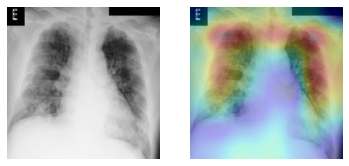

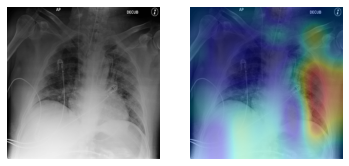

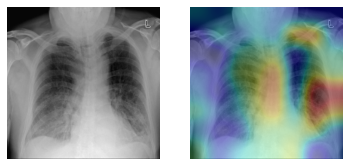

In [25]:
# Interpretation
import captum.attr
import matplotlib.pyplot as plt

path = '/content/covidx'
all_names = os.listdir(path)[:500]
all_labels = [int(name.split('_')[1]) for name in all_names]
splits = [0.8, 0.1, 0.1]
train_size, val_size, test_size = splits
trn_names, val_names, tst_names = get_splits(all_names, train_size, val_size,
                                              test_size, all_labels)
_, _, test_loader = get_data_loaders(
    ['train', 'val', 'test'],
    path, [trn_names, val_names, tst_names],
    augment=True,
    aug_prob=0.5,
    batch_size=1
    )

cnt = 0
for batch_num, sample in enumerate(test_loader):
  X, label = sample

  gcObj = captum.attr.LayerGradCam(model.forward, model.layer4)     
  if label.item() == 0:
    continue                            
  attr = gcObj.attribute(X.cuda(), int(label.item()))                                                                     
  attr = torch.abs(attr)                                                                                  
  attrRescaled = Image.fromarray(attr.detach().cpu()                                                      
                                 .numpy()[0, 0, :, :]).resize(                                            
                                 (X.shape[3], X.shape[2]))
  img = X[0].permute(1, 2, 0).numpy()
  img = img.astype('float')
  img = (img - np.max(img)) / (np.max(img) - np.min(img))
  attr_map = np.array(attrRescaled)

  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow((img*255).astype('uint8'), cmap='gray')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow((img*255).astype('uint8'), cmap='gray')
  plt.imshow(attr_map, cmap='jet', alpha=0.3)  
  plt.axis('off')
#   plt.colorbar()
  plt.show()                 
  cnt += 1
  if cnt >= 10:
    break

# **Excercise**

---



*   Plot the confusion matrix
*   Check other metrics




# **Resources**

---


* Try tensorboard  
* Check out [Weights and Biases](https://wandb.ai/site)


